# Realistic experiment

*Want to follow along? {nb-download}`Download this notebook.<4. advanced demo.ipynb>`*

In [1]:
from __future__ import annotations

import math

from deltakit.explorer import types


def get_noise(t_m: float) -> types.PhysicalNoiseModel:
    """Get a superconducting noise model based on measurement time"""
    t1, t2 = 20e-6, 20e-6
    t1_ns = t1 * 1e9
    measurement_time_ns = t_m * 1e9
    time_resonator_decays_ns = 60.0
    # readout error according to
    # https://arxiv.org/abs/2107.13589 - formulas 42, 43
    readout_error = 0.5 - 0.5 * math.exp(
        -(measurement_time_ns / (2 * t1_ns))
    ) * math.erf(math.sqrt(measurement_time_ns / (2 * time_resonator_decays_ns)))
    time_2q_gate_ns = 1.5e6 ** (1 / 6.7) * (t1_ns ** (1 / 6.7))
    error_2q = 3 * 1.5e6 * (time_2q_gate_ns ** (-5.7))
    time_1q_gate_reference_ns = 18.205642030260805
    r = (time_1q_gate_reference_ns**5) / t1_ns
    time_1q_gate_ns = (r * t1_ns) ** (1.0 / 5.0)
    error_1q = 1.06374 * (
        time_1q_gate_ns / t1_ns + (r / 4) * (1 / time_1q_gate_ns) ** 4
    )
    reset_time = time_resonator_decays_ns * 6 * 1e-9
    return types.PhysicalNoiseModel(
        t_1=t1,
        t_2=t2,
        time_1_qubit_gate=time_1q_gate_ns * 1e-9,
        time_2_qubit_gate=time_2q_gate_ns * 1e-9,
        time_measurement=t_m,
        time_reset=reset_time,
        p_1_qubit_gate_error=error_1q,
        p_2_qubit_gate_error=error_2q,
        p_reset_error=readout_error,
        p_meas_qubit_error=readout_error,
        p_readout_flip=readout_error,
    )

In [2]:
import numpy as np
from deltakit.explorer import Client, enums

client = Client.get_instance()
tunable_coupler_gates = ["H", "X", "Z", "SQRT_X", "CZ", "RZ", "MZ"]
experiment = types.QECExperimentDefinition.get_rotated_planar_z_quantum_memory(
    distance=3, num_rounds=3,
    basis_gates=tunable_coupler_gates
)
circuit = client.generate_circuit(experiment)

times = np.linspace(3e-7, 6.5e-7, 11)
dec_errors = []
mmt_errors = []
for t_m in times:

    # this is what we changed in the original workflow
    noise = get_noise(t_m)
    mmt_errors.append(noise.p_meas_qubit_error)
    noisy_circuit = client.add_noise(circuit, noise)

    measurements, _ = client.simulate_stim_circuit(noisy_circuit, 200_000)
    detectors, observables = measurements.to_detectors_and_observables(noisy_circuit)

    decoder = types.Decoder(enums.DecoderType.MWPM)
    decoding_result = client.decode(detectors, observables, decoder, noisy_circuit)
    dec_errors.append(decoding_result.get_logical_error_probability())

decoding batches: 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]


Let us visualise what happens to measurement quality, and what - to QEC:

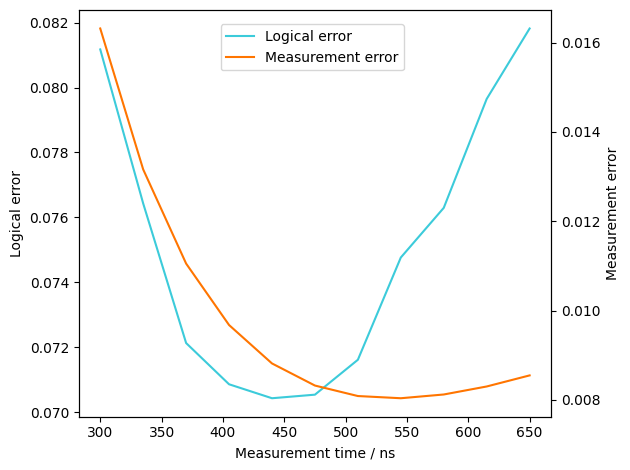

In [3]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("Measurement time / ns")
ax1.set_ylabel("Logical error")
ax2.set_ylabel("Measurement error")
ax1.plot(times*1e9, dec_errors, label="Logical error", color="#3ccbda")
ax2.plot(times*1e9, mmt_errors, label="Measurement error", color="#ff7500")
fig.tight_layout()
fig.legend(loc=(0.35, 0.85))
plt.show()